# Classifier on Particle Track Data

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
import numpy as np
import math

## Get angle values and cast to boolean

In [3]:
track_params = pd.read_csv('../TRAIN/track_parms.csv')

In [4]:
track_params.tail()

,filename,phi,z,phi_calc,phi_regression,sigma_regression
499995,img499995.png,-4.509653,0.968584,-4.494071,-4.494040,0.014105
499996,img499996.png,-1.595661,-7.397094,-1.645501,-1.645483,0.014181
499997,img499997.png,7.695264,-2.984060,7.799254,7.799186,0.013931
499998,img499998.png,-1.898667,5.082713,-1.880849,-1.880834,0.014177
499999,img499999.png,4.275843,-2.266920,4.324348,4.324317,0.014112


## Create our simple classification target

In [5]:
# Create binary labels
track_params['phi_bool'] = track_params.phi.apply(lambda x: "+" if x > 0 else "-")

# Bin the phi values to get multi-class labels
track_params['phi_binned'], phi_bins = pd.cut(track_params.phi, bins=11,
                                              retbins=True)
track_params['phi_binned'] = track_params['phi_binned'].astype(str)

# Bin the z values to get multi-class labels
track_params['z_binned'], z_bins = pd.cut(track_params.z, bins=11,
                                           retbins=True)
track_params['z_binned'] = track_params['z_binned'].astype(str)

## Look at the distributions to see if we have any imbalances

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12ab8b320>,
      dtype=object)

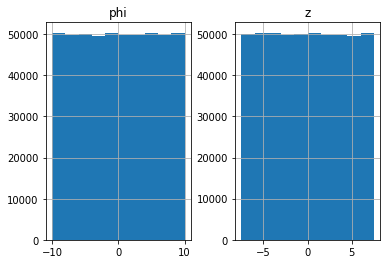

In [10]:
track_params[['phi', 'z']].hist()

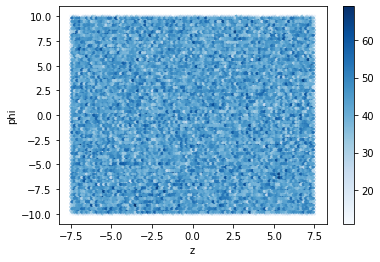

In [7]:
track_params.plot(x='z', y='phi', kind='hexbin', sharex=False, cmap="Blues")

* looks like a perfectly balanced dataset to me, so we don't have to worry about the type of complications that arise from am imbalanced set.

In [11]:
track_params.head()

,filename,phi,z,phi_calc,phi_regression,sigma_regression,phi_bool,phi_binned,z_binned
0,img000000.png,-0.195900,-5.164839,-0.206930,-0.206928,0.014192,-,"(-0.909, 0.909]","(-6.136, -4.773]"
1,img000001.png,-1.473349,5.784543,-1.409622,-1.409614,0.014184,-,"(-2.727, -0.909]","(4.773, 6.136]"
2,img000002.png,9.206585,-2.295192,9.296442,9.296330,0.016293,+,"(8.182, 10.0]","(-3.409, -2.045]"
3,img000003.png,5.378890,4.685070,5.281532,5.281474,0.014072,+,"(4.545, 6.364]","(3.409, 4.773]"
4,img000004.png,-6.700401,-0.851756,-6.739551,-6.739504,0.013997,-,"(-8.182, -6.364]","(-2.045, -0.682]"


## Also prepare our holdout set for later

In [12]:
holdout_track_params = pd.read_csv('../VALIDATION/track_parms.csv')

holdout_track_params['phi_bool'] = (
    holdout_track_params
    .phi
    .apply(lambda x: "+" if x > 0 else "-")
)
holdout_track_params['phi_binned'] = pd.cut(
    holdout_track_params['phi'],
    bins=phi_bins
)
holdout_track_params['phi_binned'] = holdout_track_params['phi_binned'].astype(str)



holdout_track_params['z_binned'] = pd.cut(
    holdout_track_params['z'],
    bins=z_bins
)
holdout_track_params['z_binned'] = holdout_track_params['z_binned'].astype(str)

## Create an image generator from this dataframe

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [41]:
DATAGEN = ImageDataGenerator(rescale=1./255.,
                             validation_split=0.25)

In [43]:
height = 100
width = 36

def create_generator(target, subset, class_mode,
                     idg=DATAGEN, df=track_params, N=1000):
    
    return idg.flow_from_dataframe(
        dataframe=track_params.head(N),
        directory="../TRAIN",
        x_col="filename",
        y_col=target,
        subset=subset,
        target_size=(height, width),
        batch_size=32,
        seed=314,
        shuffle=True,
        class_mode=class_mode,
    )

In [44]:
binary_train_generator = create_generator(
    target="phi_bool",
    subset="training",
    class_mode="binary"
)
binary_val_generator = create_generator(
    target="phi_bool",
    subset="validation",
    class_mode="binary"
)

Found 750 validated image filenames belonging to 2 classes.
Found 250 validated image filenames belonging to 2 classes.


## Create a very simple convolutional model from scratch

In [165]:
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import (
    Conv2D, Activation, MaxPooling2D,
    Flatten, Dense, Dropout, Input
)

### Model Definition

In [30]:
width  = 36
height = 100
channels = 3

def binary_classifier():
    model = Sequential()

    # Layer 1
    model.add(Conv2D(32, (3, 3), input_shape=(height, width, channels)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Layer 2
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Layer 3
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Dense, Classification Layer
    model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    return model

## Train this model

In [61]:
STEP_SIZE_TRAIN = binary_train_generator.n//binary_train_generator.batch_size
STEP_SIZE_VAL = binary_val_generator.n//binary_val_generator.batch_size

In [62]:
binary_model = binary_classifier()
binary_history = binary_model.fit_generator(
    generator=binary_train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=binary_val_generator,
    validation_steps=STEP_SIZE_VAL,
    epochs=5
)

Epoch 1/5
23/23 [==============================] - 3s 118ms/step - loss: 0.1806 - accuracy: 0.9666 - val_loss: 0.0036 - val_accuracy: 1.0000
Epoch 2/5
23/23 [==============================] - 2s 70ms/step - loss: 0.0027 - accuracy: 0.9986 - val_loss: 4.6997e-05 - val_accuracy: 1.0000
Epoch 3/5
23/23 [==============================] - 2s 72ms/step - loss: 1.0893e-04 - accuracy: 1.0000 - val_loss: 9.1072e-06 - val_accuracy: 1.0000
Epoch 4/5
23/23 [==============================] - 2s 72ms/step - loss: 5.7561e-05 - accuracy: 1.0000 - val_loss: 6.2832e-06 - val_accuracy: 1.0000
Epoch 5/5
23/23 [==============================] - 2s 69ms/step - loss: 9.0745e-05 - accuracy: 1.0000 - val_loss: 3.7304e-06 - val_accuracy: 1.0000


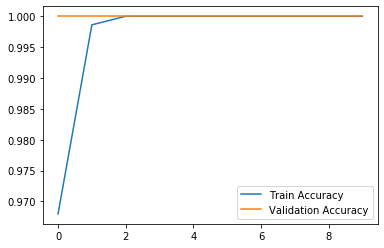

In [63]:
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.legend()
plt.show()

## Okay, maybe that was too easy

* I mean, if any pixels are lit up on the top half / bottom half, it's a smoking gun.
* Let's make it harder with binned measurements and treat it as categorical.

In [48]:
mc_train_generator = create_generator(
    target="phi_binned",
    subset="training",
    class_mode="categorical",
    N=10000
)
mc_val_generator = create_generator(
    target="phi_binned",
    subset="validation",
    class_mode="categorical",
    N=10000
)

Found 7500 validated image filenames belonging to 11 classes.
Found 2500 validated image filenames belonging to 11 classes.


## Similar model, with some tweaks

In [290]:
width  = 36
height = 100
channels = 3

def multiclass_classifier():
    model = Sequential()

    # Layer 1
    model.add(Conv2D(32, (3, 3), input_shape=(height, width, channels)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Layer 2
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Layer 3
    #model.add(Conv2D(64, (3, 3)))
    #model.add(Activation('relu'))
    #model.add(MaxPooling2D(pool_size=(2, 2)))

    # Dense, Classification Layer
    model.add(Flatten())
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(11))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    return model

In [287]:
STEP_SIZE_TRAIN = mc_train_generator.n//mc_train_generator.batch_size
STEP_SIZE_VAL = mc_val_generator.n//mc_val_generator.batch_size

In [288]:
mc_model = multiclass_classifier()
mc_history = mc_model.fit_generator(
    generator=mc_train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=mc_val_generator,
    validation_steps=STEP_SIZE_VAL,
    epochs=15
)

Epoch 1/15
234/234 [==============================] - 10s 45ms/step - loss: 0.2201 - accuracy: 0.9380 - val_loss: 0.0744 - val_accuracy: 0.9744
Epoch 2/15
234/234 [==============================] - 8s 34ms/step - loss: 0.0959 - accuracy: 0.9651 - val_loss: 0.0634 - val_accuracy: 0.9748
Epoch 3/15
234/234 [==============================] - 8s 35ms/step - loss: 0.0771 - accuracy: 0.9721 - val_loss: 0.0521 - val_accuracy: 0.9772
Epoch 4/15
234/234 [==============================] - 8s 34ms/step - loss: 0.0655 - accuracy: 0.9740 - val_loss: 0.0374 - val_accuracy: 0.9824
Epoch 5/15
234/234 [==============================] - 8s 34ms/step - loss: 0.0601 - accuracy: 0.9774 - val_loss: 0.0404 - val_accuracy: 0.9852
Epoch 6/15
234/234 [==============================] - 8s 34ms/step - loss: 0.0536 - accuracy: 0.9795 - val_loss: 0.0333 - val_accuracy: 0.9848
Epoch 7/15
234/234 [==============================] - 8s 34ms/step - loss: 0.0465 - accuracy: 0.9835 - val_loss: 0.0337 - val_accuracy: 0.984

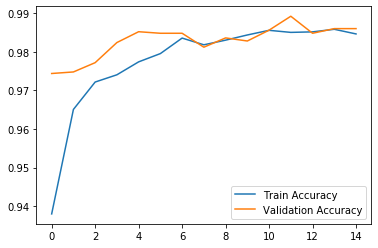

In [289]:
plt.plot(mc_history.history['accuracy'], label="Train Accuracy")
plt.plot(mc_history.history['val_accuracy'], label="Validation Accuracy")
plt.legend()
plt.show()

In [291]:
mc_model = multiclass_classifier()
mc_history = mc_model.fit_generator(
    generator=mc_train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=mc_val_generator,
    validation_steps=STEP_SIZE_VAL,
    epochs=15
)

Epoch 1/15
234/234 [==============================] - 16s 66ms/step - loss: 0.2912 - accuracy: 0.9104 - val_loss: 0.0862 - val_accuracy: 0.9659
Epoch 2/15
234/234 [==============================] - 14s 61ms/step - loss: 0.1302 - accuracy: 0.9565 - val_loss: 0.0741 - val_accuracy: 0.9740
Epoch 3/15
234/234 [==============================] - 15s 62ms/step - loss: 0.1011 - accuracy: 0.9632 - val_loss: 0.0630 - val_accuracy: 0.9772
Epoch 4/15
234/234 [==============================] - 14s 62ms/step - loss: 0.0815 - accuracy: 0.9713 - val_loss: 0.0613 - val_accuracy: 0.9772
Epoch 5/15
234/234 [==============================] - 14s 61ms/step - loss: 0.0769 - accuracy: 0.9709 - val_loss: 0.0499 - val_accuracy: 0.9800
Epoch 6/15
234/234 [==============================] - 15s 63ms/step - loss: 0.0664 - accuracy: 0.9762 - val_loss: 0.0427 - val_accuracy: 0.9828
Epoch 7/15
234/234 [==============================] - 15s 62ms/step - loss: 0.0610 - accuracy: 0.9772 - val_loss: 0.0411 - val_accuracy:

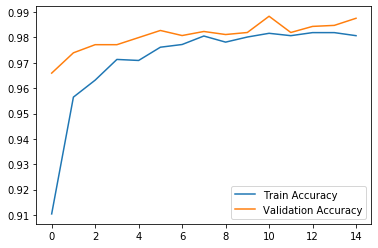

In [292]:
plt.plot(mc_history.history['accuracy'], label="Train Accuracy")
plt.plot(mc_history.history['val_accuracy'], label="Validation Accuracy")
plt.legend()
plt.show()

In [70]:
holdout_track_params.head()

,filename,phi,z,phi_calc,phi_regression,sigma_regression,phi_bool,phi_binned,z_binned
0,img000000.png,-9.485965,-3.828900,-9.686028,-9.685839,0.018073,-,"(-10.02, -8.182]","(-4.773, -3.409]"
1,img000001.png,-3.074625,2.163597,-3.051685,-3.051679,0.014152,-,"(-4.545, -2.727]","(2.045, 3.409]"
2,img000002.png,4.309261,7.374503,4.176042,4.176005,0.014117,+,"(2.727, 4.545]","(6.136, 7.5]"
3,img000003.png,7.658805,1.729064,7.596692,7.596633,0.013945,+,"(6.364, 8.182]","(0.682, 2.045]"
4,img000004.png,-0.531445,6.179114,-0.498643,-0.498641,0.014192,-,"(-0.909, 0.909]","(6.136, 7.5]"


In [124]:
mc_holdout_generator = datagen.flow_from_dataframe(
    dataframe=holdout_track_params,
    directory="../VALIDATION",
    x_col="filename",
    y_col="phi_binned",
    subset=None,
    target_size=(height, width),
    batch_size=32,
    seed=314,
    shuffle=False,
    class_mode="categorical",
)

Found 50000 validated image filenames belonging to 11 classes.


In [125]:
holdout_track_params['y_pred'] = mc_model.predict_classes(mc_holdout_generator)

In [126]:
holdout_track_params['y_true'] = mc_holdout_generator.classes

In [127]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [128]:
class_names = [x for x in mc_holdout_generator.class_indices.keys()]

Confusion matrix, without normalization
[[4502    0   11    0    0    0   12    0    0    0    0]
 [   0 4487    0    0    0   30    0    0    0    0    0]
 [  32    0 4512    4    0    0    0    0    0    0    0]
 [   0    0   63 4283   26    0    0    0    0    0    0]
 [   0    0    0   44 4520   12    0    0    0    0    0]
 [   0  125    0    0   94 4369    0    0    0    0    0]
 [  20    0    0    0    0    0 4579    5    0    0    0]
 [   0    0    0    0    0    0   72 4453   61    0    0]
 [   0    0    0    0    0    0    0   29 4508  128    0]
 [   0    0    0    0    0    0    0    0   29 4281  191]
 [   0    0    0    0    0    0    0    0    0   31 4487]]


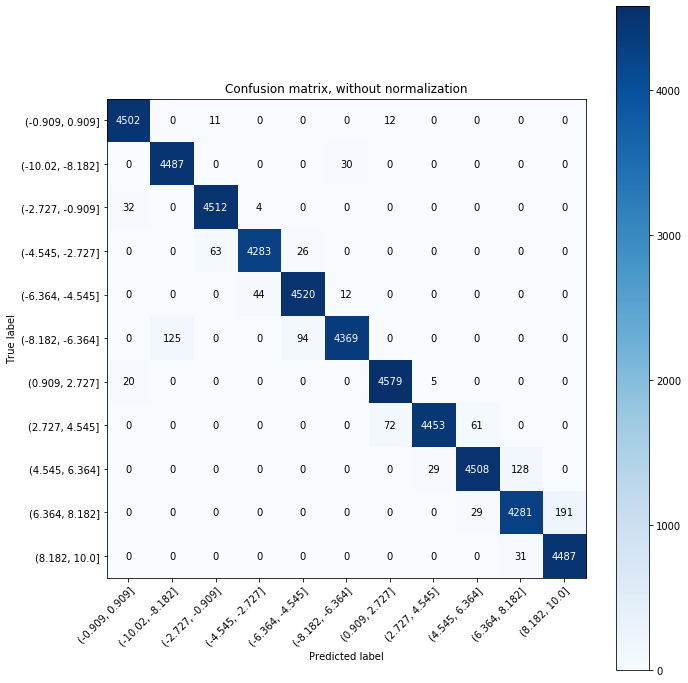

In [129]:
plot_confusion_matrix(holdout_track_params['y_true'],
                      holdout_track_params['y_pred'],
                      classes=class_names)

## Let's Try Regression

In [52]:
reg_train_generator = create_generator(
    target="phi",
    subset="training",
    class_mode="raw",
    N=10000
)
reg_val_generator = create_generator(
    target="phi",
    subset="validation",
    class_mode="raw",
    N=10000
)

Found 7500 validated image filenames.
Found 2500 validated image filenames.


## Similar model, with some tweaks

In [159]:
width  = 36
height = 100
channels = 3

def regression_model():
    model = Sequential()

    # Layer 1
    model.add(Conv2D(32, (3, 3), input_shape=(height, width, channels)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Layer 2
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Layer 3
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Dense regression layer
    model.add(Flatten())
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))

    model.compile(loss='mean_squared_error',
                  optimizer='adam',
                  metrics=['mse'])
    
    return model

In [67]:
STEP_SIZE_TRAIN = reg_train_generator.n//reg_train_generator.batch_size
STEP_SIZE_VAL = reg_val_generator.n//reg_val_generator.batch_size

In [68]:
reg_model = regression_model()
reg_history = reg_model.fit_generator(
    generator=reg_train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=reg_val_generator,
    validation_steps=STEP_SIZE_VAL,
    epochs=15
)

Epoch 1/15
234/234 [==============================] - 17s 71ms/step - loss: 2.6697 - mse: 2.6760 - val_loss: 0.1029 - val_mse: 0.1029
Epoch 2/15
234/234 [==============================] - 17s 73ms/step - loss: 1.3122 - mse: 1.3144 - val_loss: 0.2189 - val_mse: 0.2189
Epoch 3/15
234/234 [==============================] - 16s 70ms/step - loss: 1.3365 - mse: 1.3346 - val_loss: 0.2514 - val_mse: 0.2514
Epoch 4/15
234/234 [==============================] - 16s 69ms/step - loss: 1.2973 - mse: 1.2975 - val_loss: 0.2112 - val_mse: 0.2112
Epoch 5/15
234/234 [==============================] - 16s 67ms/step - loss: 1.2508 - mse: 1.2515 - val_loss: 0.2013 - val_mse: 0.2013
Epoch 6/15
234/234 [==============================] - 16s 67ms/step - loss: 1.2476 - mse: 1.2486 - val_loss: 0.1091 - val_mse: 0.1091
Epoch 7/15
234/234 [==============================] - 16s 69ms/step - loss: 1.1753 - mse: 1.1762 - val_loss: 0.5386 - val_mse: 0.5386
Epoch 8/15
234/234 [==============================] - 16s 67ms

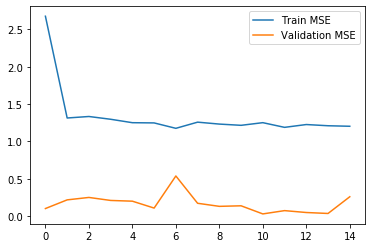

In [69]:
plt.plot(reg_history.history['mse'], label="Train MSE")
plt.plot(reg_history.history['val_mse'], label="Validation MSE")
plt.legend()
plt.show()

## Attempt to train for both z and $\theta$

In [225]:
double_reg_train_generator = create_generator(
    target=["z", "phi"],
    subset="training",
    class_mode="raw",
    N=100000
)
double_reg_val_generator = create_generator(
    target=["z", "phi"],
    subset="validation",
    class_mode="raw",
    N=100000
)

Found 75000 validated image filenames.
Found 25000 validated image filenames.


## Similar model, with some tweaks

In [226]:
width  = 36
height = 100
channels = 3

def double_regression_model():
    
    model = Sequential()

    # Layer 1
    model.add(Conv2D(32, (3, 3), input_shape=(height, width, channels)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Layer 2
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Layer 3
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Dense regression layer
    model.add(Flatten())
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2))

    model.compile(optimizer="adam",
                  loss="mean_squared_error",
                  metrics=["mse"])
    return model

In [227]:
STEP_SIZE_TRAIN = double_reg_train_generator.n//double_reg_train_generator.batch_size
STEP_SIZE_VAL = double_reg_val_generator.n//double_reg_val_generator.batch_size

In [228]:
double_reg_model = double_regression_model()
double_reg_history = double_reg_model.fit_generator(
    generator=double_reg_train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=double_reg_val_generator,
    validation_steps=STEP_SIZE_VAL,
    epochs=15
)

Epoch 1/15
2343/2343 [==============================] - 164s 70ms/step - loss: 5.7755 - mse: 5.7749 - val_loss: 2.1561 - val_mse: 2.1561
Epoch 2/15
2343/2343 [==============================] - 164s 70ms/step - loss: 3.4980 - mse: 3.4981 - val_loss: 1.6251 - val_mse: 1.6251
Epoch 3/15
2343/2343 [==============================] - 163s 70ms/step - loss: 3.1128 - mse: 3.1128 - val_loss: 1.5244 - val_mse: 1.5244
Epoch 4/15
2343/2343 [==============================] - 174s 74ms/step - loss: 2.9330 - mse: 2.9331 - val_loss: 1.0528 - val_mse: 1.0528
Epoch 5/15
2343/2343 [==============================] - 178s 76ms/step - loss: 2.7956 - mse: 2.7956 - val_loss: 1.1486 - val_mse: 1.1486
Epoch 6/15
2343/2343 [==============================] - 1328s 567ms/step - loss: 2.6723 - mse: 2.6724 - val_loss: 0.9951 - val_mse: 0.9951
Epoch 7/15
2343/2343 [==============================] - 167s 71ms/step - loss: 2.5707 - mse: 2.5705 - val_loss: 0.7356 - val_mse: 0.7356
Epoch 8/15
2343/2343 [=================

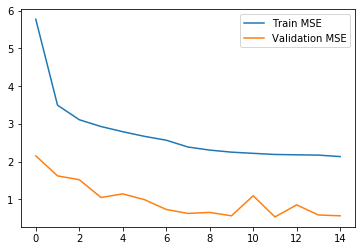

In [233]:
plt.plot(double_reg_history.history['mse'], label="Train MSE")
plt.plot(double_reg_history.history['val_mse'], label="Validation MSE")
plt.legend()
plt.show()

In [234]:
double_reg_holdout_generator = datagen.flow_from_dataframe(
    dataframe=holdout_track_params,
    directory="../VALIDATION",
    x_col="filename",
    y_col=["z", "phi"],
    subset=None,
    target_size=(height, width),
    batch_size=32,
    seed=314,
    shuffle=False,
    class_mode="raw",
)

Found 50000 validated image filenames.


In [235]:
holdout_track_params['z_pred'] = 0.0
holdout_track_params['phi_pred'] = 0.0

In [236]:
y_pred = double_reg_model.predict(double_reg_holdout_generator)

In [238]:
holdout_track_params['z_pred'] = [y[0] for y in y_pred]
holdout_track_params['phi_pred'] = [y[1] for y in y_pred]

In [244]:
holdout_track_params['delta_z'] = holdout_track_params.eval('z - z_pred')
holdout_track_params['delta_phi'] = holdout_track_params.eval('phi - phi_pred')

In [337]:
from sklearn.metrics import r2_score, mean_squared_error

In [339]:
print(r2_score(holdout_track_params['phi'], holdout_track_params['phi_pred']))
print(mean_squared_error(holdout_track_params['phi'], holdout_track_params['phi_pred']))

0.9928630409656668
0.23771266379734832


In [341]:
print(r2_score(holdout_track_params['z'], holdout_track_params['z_pred']))
print(mean_squared_error(holdout_track_params['z'], holdout_track_params['z_pred']))

0.951504767803148
0.9107334942532787


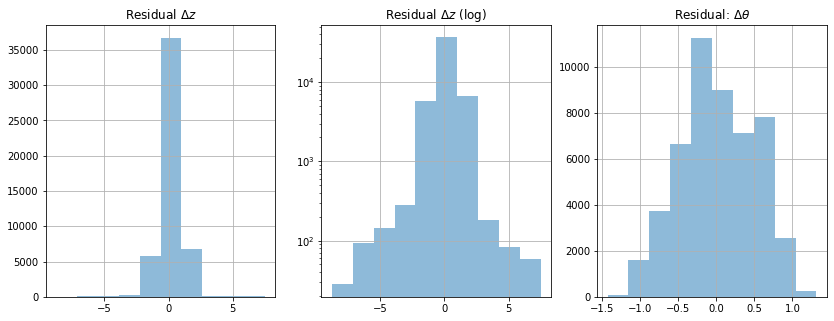

In [345]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(14, 5))
holdout_track_params['delta_z'].hist(bins=10, alpha=0.5,
                                     log=False, ax=ax0)
holdout_track_params['delta_z'].hist(bins=10, alpha=0.5,
                                     log=True, ax=ax1)
holdout_track_params['delta_phi'].hist(bins=10, ax=ax2,
                                       alpha=0.5)
ax0.set_title(r'Residual $\Delta z$')
ax1.set_title(r'Residual $\Delta z$ (log)')
ax2.set_title(r'Residual: $\Delta\theta$')
plt.show()

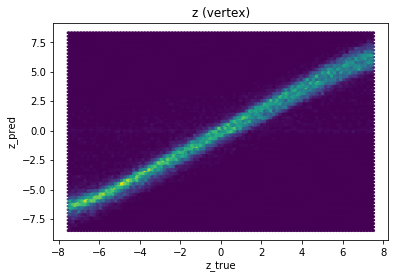

In [278]:
plt.hexbin(x=holdout_track_params['z'], y=holdout_track_params['z_pred'])
_ = plt.title('z (vertex)')
_ = plt.xlabel('z_true')
_ = plt.ylabel('z_pred')

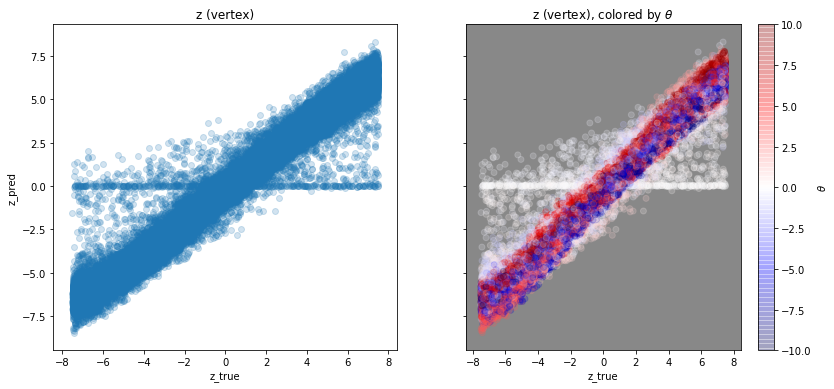

In [354]:
from matplotlib import cm

fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2,
                               figsize=(12, 6),
                               sharex=True,
                               sharey=True)
scatter = plt.scatter(x=holdout_track_params['z'],
                      y=holdout_track_params['z_pred'],
                      c=holdout_track_params['phi'],
                      cmap=cm.seismic,
                      vmin=-10., vmax=10.,
                      alpha=0.2)
plt.colorbar(scatter, label=r'$\theta$')
ax1.set_facecolor("#888888")
_ = plt.title(r'z (vertex), colored by $\theta$')
_ = plt.xlabel('z_true')

plt.sca(ax0)
scatter = plt.scatter(x=holdout_track_params['z'],
                      y=holdout_track_params['z_pred'],
                      alpha=0.2)
_ = plt.title('z (vertex)')
_ = plt.xlabel('z_true')
_ = plt.ylabel('z_pred')

plt.subplots_adjust(right=1.)

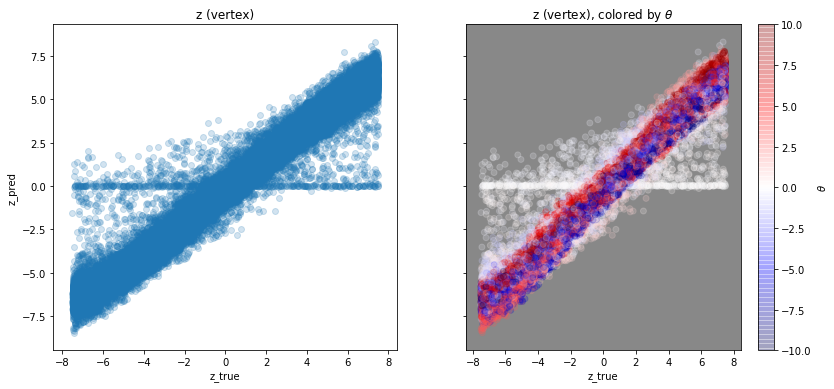

In [354]:
from matplotlib import cm

fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2,
                               figsize=(12, 6),
                               sharex=True,
                               sharey=True)
scatter = plt.scatter(x=holdout['z'],
                      y=holdout['z_pred'],
                      c=holdout['theta'],
                      cmap=cm.seismic,
                      vmin=-10., vmax=10.,
                      alpha=0.2)
plt.colorbar(scatter, label=r'$\theta$')
ax1.set_facecolor("#888888")
_ = plt.title(r'z (vertex), colored by $\theta$')
_ = plt.xlabel('z_true')

plt.sca(ax0)
scatter = plt.scatter(x=holdout['z'],
                      y=holdout['z_pred'],
                      alpha=0.2)
_ = plt.title('z (vertex)')
_ = plt.xlabel('z_true')
_ = plt.ylabel('z_pred')

plt.subplots_adjust(right=1.)

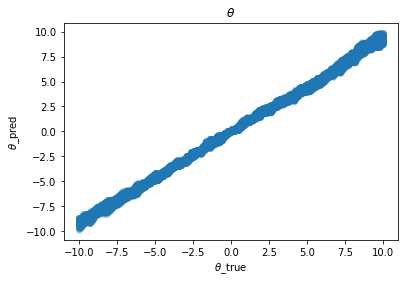

In [281]:
plt.scatter(x=holdout_track_params['phi'], y=holdout_track_params['phi_pred'],
            alpha=0.2)
_ = plt.title(r'$\theta$')
_ = plt.xlabel(r'$\theta$_true')
_ = plt.ylabel(r'$\theta$_pred')

## Calculate scoring criteria

In [282]:
holdout_track_params['z_squared_error'] = holdout_track_params.eval(
    '(z - z_pred) ** 2'
)

In [283]:
holdout_track_params['phi_squared_error'] = holdout_track_params.eval(
    '(phi - phi_pred) ** 2'
)

In [285]:
holdout_track_params[['z_squared_error', 'phi_squared_error']].sum()

z_squared_error      45536.674713
phi_squared_error    11885.633190
dtype: float64